In [1]:
%matplotlib inline
from pylab import *
import xarray as xr
from xgcm import Grid
import scipy.signal as sig
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

In [2]:
basedir='/vortexfs1/home/ilebras/'
datadir=basedir+'data/'
figdir=basedir+'figures/NASA_AMOC/October2022_paperfigs/'

In [3]:
LW=xr.open_dataset(datadir+'LineW/LineW_moorings_dailygridded_April2021.nc')

In [4]:
LW.dist

<xarray.DataArray 'dist' (dist: 6)>
array([ 86.091774, 134.690764, 183.520825, 234.251485, 277.918471, 352.858532])
Coordinates:
    moor     (dist) object ...
    lat      (dist) float64 ...
    lon      (dist) float64 ...
  * dist     (dist) float64 86.09 134.7 183.5 234.3 277.9 352.9

In [5]:
date_start='2004-5-1'
date_end='2014-5-1'

In [6]:
LWmerge=xr.open_dataset(datadir+'NASA_AMOC/Section35N_Step3.nc').sel(date=slice(date_start,date_end))

In [7]:
dmap=xr.open_dataset(datadir+'Willis/August2022/amoc_diff_velmap.nc')
xray=xr.open_dataset(datadir+'Willis/ilebras/Willis_allvars_Aug2022.nc')
dmap['date']=(['time'],xray.date.values)
dmap=dmap.swap_dims({'time':'date'})
dmap=dmap.sel(date=slice(date_start,date_end)).mean(dim='date')
dmap['lon']=dmap.lon-360

In [8]:
speed=sqrt(dmap.umap**2+dmap.vmap**2)

In [9]:
from mpl_toolkits.basemap import Basemap, shiftgrid
from mpl_toolkits.basemap import cm as bcm

map = Basemap(llcrnrlon=-80.,llcrnrlat=21.,urcrnrlon=0.,urcrnrlat=51.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)


In [12]:
latch=35
lonx=LW.lon[0]+(LW.lon[4]-LW.lon[0])*(latch-LW.lat[0])/(LW.lat[4]-LW.lat[0])

In [13]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

In [14]:
vmini=-15
vmaxi=60
zeropt=-vmini/(vmaxi-vmini)
new_cmap=make_cmap([(5,48,97),(33,102,172),(247,247,247),(103,0,31)],[0,zeropt/2,zeropt,1],bit=True)

In [15]:
#left over from when I was plotting Line W data instead of merged product
# def grid4plot(var):
#     varnew=var.copy()
#     for ii,mm in enumerate(LW.moor):
#         nanind=isnan(var[:,ii])
#         nonanind=~isnan(var[:,ii])
#         varnew[nanind,ii]=var[nonanind,ii][-1]

#     varfin=vstack(([varnew[:,0],varnew[:,0],varnew[:,1],varnew[:,2],varnew[:,3],varnew[:,4],varnew[:,5],varnew[:,5]]))
#     newdist=hstack(([LW.dist.values[0]-15,LW.dist.values,LW.dist.values[-1]+15]))

#     return newdist,varfin.T

In [16]:
from scipy import io
lwbathy=io.loadmat(datadir+'LineW/line_w_bathy.mat')
lwb_dist=lwbathy['dist'].flatten()
lwb_z=lwbathy['z'].flatten()

In [17]:
def max_out_for_cbar(mat,vmini,vmaxi):
    mat_fixed=mat.copy()
    mat_fixed[mat_fixed>vmaxi]=vmaxi
    mat_fixed[mat_fixed<vmini]=vmini
    return mat_fixed

In [18]:
lonmat,latmat=meshgrid(dmap.lon,dmap.lat)

In [19]:
LWmoor_trans=xr.open_dataset(datadir+'NASA_AMOC/LWtrans_moor.nc')
Willis_LWtrans=xr.open_dataset(datadir+'NASA_AMOC/LWtrans_Willis.nc')

In [20]:
def smoothfunc(tseries):
   # Design the Buterworth filter
    ## 2nd order 3 month default filter
    N  = 2    # Filter order
    Wn = 1/(365.25/4) # Cutoff frequency (3 months)
    B, A = sig.butter(N, Wn, output='ba')
    tseries_sm=sig.filtfilt(B,A,tseries)
    return tseries_sm

In [21]:
279+25

304

<ipython-input-40-94773611465d>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([str(ii) for ii in range(2004,2015)],rotation=0,ha='center');


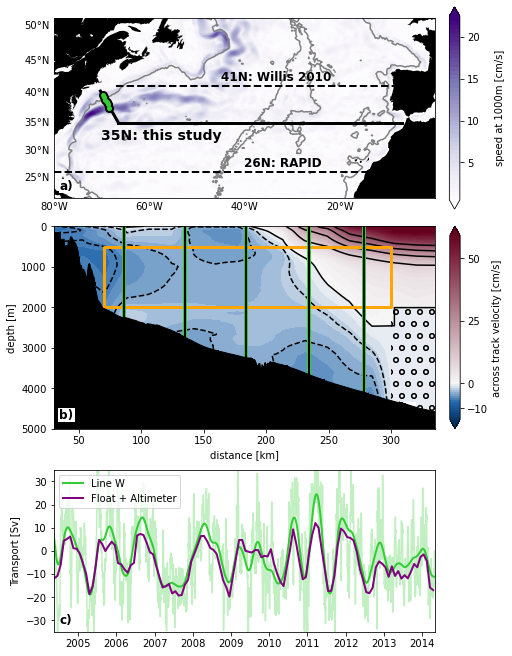

In [40]:
fig = plt.figure(constrained_layout=True,figsize=(7,9))
spec = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[1.25,1.25,1],hspace=0.2)
aspct=15
ax1=fig.add_subplot(spec[0,0])
map.contour(lonmat,latmat,dmap.bathy,levels=[-3000],latlon=True,colors='grey',linestyles='solid')
map.contourf(lonmat,latmat,speed.values*100,51,latlon=True,cmap=cm.Purples,extend='both')
colorbar(label='\nspeed at 1000m [cm/s]',ticks=arange(-5,20.5,5),aspect=aspct)
map.plot([LWmerge.loni[0], lonx],[LWmerge.lat[0],35],'-',color='k',latlon=True,linewidth=3)
map.plot([lonx,-7],[35,35],'-',latlon=True,linewidth=3,color='k')
map.plot(LW.lon.values,LW.lat.values,'ko',latlon=True,markersize=8)
map.plot(LW.lon.values,LW.lat.values,'o',color='limegreen',latlon=True,markersize=4,linewidth=4)
map.plot([-67,-7],[41,41],'--',color='k',latlon=True,linewidth=2)
x1,y1=map(-40,27)
ax1.text(x1,y1,'26N: RAPID',color='k',fontsize=12,weight='bold')
x1,y1=map(-45,42)
ax1.text(x1,y1,'41N: Willis 2010',color='k',fontsize=12,weight='bold')
# x1,y1=map(-33,36)
# ax1.text(x1,y1,'MAR',color='k',fontsize=14,weight='bold')
x1,y1=map(-70,32)
ax1.text(x1,y1,'35N: this study',color='k',fontsize=14,weight='bold')
map.plot([-80,-14],[26,26],'--',color='k',latlon=True,linewidth=2)

map.fillcontinents(color='k',zorder=80);
map.drawparallels(np.arange(10,90,5),labels=[1,0,0,1],linewidth=0.0001,ax=ax1)
map.drawmeridians(np.arange(-180,180,20),labels=[1,1,0,1],linewidth=0.0001,ax=ax1)
#############
distmax=350
ax2=fig.add_subplot(spec[1,0])
vg_linew=100*LWmerge['vg'].sel(dist=slice(0,LW.dist[4]+10)).mean(dim='date').interpolate_na(dim='depth',method='linear',fill_value='extrapolate')
vg_beyond=100*(LWmerge['trans_tot']/LWmerge['distdiff']/LWmerge['depthdiff']*1e6).sel(dist=slice(LW.dist[4]+10,distmax)).mean(dim='date')
plot_vg=max_out_for_cbar(xr.concat((vg_linew,vg_beyond),dim='dist').values,vmini,vmaxi)
contourf(LWmerge.dist.sel(dist=slice(0,distmax)),LWmerge.depth,plot_vg,101,vmin=vmini,vmax=vmaxi,cmap=new_cmap,extend='both')
colorbar(label='across track velocity [cm/s]',ticks=hstack((arange(-10,0,10),arange(0,75,25))),aspect=aspct)
contour(LWmerge.dist.sel(dist=slice(0,distmax)),LWmerge.depth,plot_vg,colors='k',levels=hstack((arange(-10,0,2),arange(0,50,10))))
x1=70
x2=300
plot([x1,x2,x2,x1,x1],[2e3,2e3,500,500,2e3],color='orange',lw=3)
# plot([x1,x2,x2,x1,x1],[2e3,2e3,500,500,2e3],color='k',lw=1)
[axvline(dd,color='limegreen',linewidth=4) for dd in LW.dist[:-1]]
[axvline(dd,color='k',linewidth=2) for dd in LW.dist[:-1]]
# fill_between([280,400],[2e3,2e3],color='grey',hatch='X')
fill_between(lwb_dist,lwb_z,6e3*ones(len(lwb_z)),color='k',zorder=100)
ylabel('depth [m]')
xlabel('distance [km]')
ylim(5e3,0)
xlim(30,distmax-15)

#############
ax3=fig.add_subplot(spec[2,0])
LWmoor_trans['__xarray_dataarray_variable__'].plot(alpha=0.3,ax=ax3,color='limegreen')
ax3.plot(LW.date,smoothfunc(LWmoor_trans['__xarray_dataarray_variable__']),color='limegreen',label='Line W',lw=2)
Willis_LWtrans['trans'].plot(label='Float + Altimeter',color='purple',ax=ax3,lw=2)
ax3.set_ylabel('Transport [Sv]')
ax3.legend(loc=2)
# title('Transport across the Line W section 500m-2000m')
ax3.set_xlim(LW.date[0].values,LW.date[-1].values)
ax3.set_ylim(-35,35)
ax3.set_xlabel('')
ax3.set_xticklabels([str(ii) for ii in range(2004,2015)],rotation=0,ha='center');
#############
labf=12
t=ax1.text(0.015,0.05,'a)',transform = ax1.transAxes,color='black',fontsize=labf,zorder=1e10,fontweight='bold')
t.set_bbox(dict(facecolor='white',linewidth=0,pad=0.5))
t=ax2.text(0.015,0.05,'b)',transform = ax2.transAxes,color='black',fontsize=labf,zorder=1e10,fontweight='bold')
t.set_bbox(dict(facecolor='white',linewidth=0,pad=1))
ax2.fill_between([300,380],[2000,2000],[5000,5000],hatch='o',alpha=0,zorder=99)
ax3.text(0.015,0.05,'c)',transform = ax3.transAxes,color='black',fontsize=labf,zorder=1e10,fontweight='bold')

savefig(figdir+'Map_LW35.png',dpi=300,bbox_inches='tight')
savefig(figdir+'Map_LW35.pdf',bbox_inches='tight')

In [20]:
LWmoor_trans['smooth']=(['date'],smoothfunc(LWmoor_trans['__xarray_dataarray_variable__']))
Willis_trans=Willis_LWtrans['trans']

In [21]:
corrcoef(LWmoor_trans['smooth'].interp(date=Willis_trans.date),Willis_trans)

array([[1.        , 0.90255184],
       [0.90255184, 1.        ]])

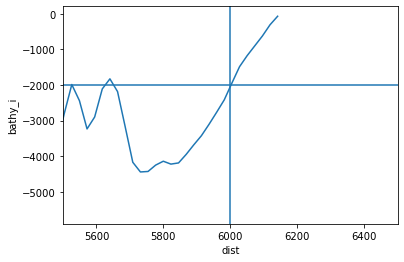

In [38]:
LWmerge.bathy_i.plot()
xlim(5.5e3,6.5e3)
axhline(-2000)
axvline(6000)

<xarray.DataArray 'trans' ()>
array(-1.73901316) <xarray.DataArray 'trans' ()>
array(0.56483875)


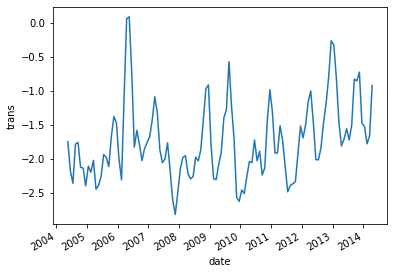

In [33]:
wbtrans=LWmerge.trans.sel(dist=slice(0,70)).sum(dim=['dist','depth'])
print(wbtrans.mean(),wbtrans.std())
wbtrans.plot()

<xarray.DataArray 'trans' ()>
array(2.47049564) <xarray.DataArray 'trans' ()>
array(2.10355472)


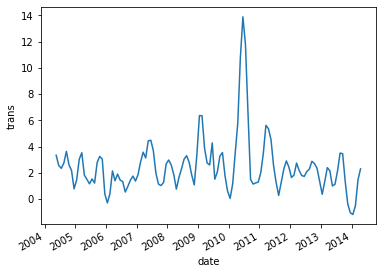

In [37]:
ebtrans=LWmerge.trans.sel(dist=slice(6e3,6.5e3)).sum(dim=['dist','depth'])
ebtrans.plot()
print(ebtrans.mean(),ebtrans.std())